In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
from numba import njit
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from scipy.spatial import KDTree

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

# import vortrace as vt
import Cvortrace
from vortrace.vortrace import ProjectionCloud

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27
textheight = 657.3189 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

# merger plot

In [4]:
sim0 = ('142', '116', '04')
sim1 = ('129', '116', '04')

In [5]:
def load_galaxy(sim, idx=320):
    Rs, Vv, ecc = sim
    key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [6]:
import importlib
importlib.reload(galaxy)

<module 'galaxy' from '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/note/galaxy.py'>

In [39]:
# idx_list = np.array([40, 80, 90, 100, 200, 320])
idx_list = np.array([60, 70, 80, 90, 100, 110, 120, 200, 320])
t_list = 0.025 * idx_list
print(t_list)

gal_idx = {}
for idx in tqdm(idx_list):
    gal_idx[idx] = load_galaxy(sim0, idx=idx)

[1.5  1.75 2.   2.25 2.5  2.75 3.   5.   8.  ]


100%|██████████| 9/9 [00:16<00:00,  1.85s/it]


In [40]:
# orient wrt last idx
gal_last = gal_idx[idx_list[-1]]
gal_last.do_orient()
k, theta = gal_last.CenterOfMass.k, gal_last.CenterOfMass.theta

for idx in tqdm(idx_list[:-1]):
    gal = gal_idx[idx]
    COM, COMV, _ = gal._get_COM_COMV()
    gal._orient(COM, COMV, k, theta)

100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


In [41]:
def plot_star_panel(fig, ax, gal, ix, iy):
    L = 30
    Nres = 256
    vmin = 1e-4
    vmax = 0.3
    sigma = 0.5

    sn, sub = gal.sn, gal.sub
    is_star = sn.part4.GFM_StellarFormationTime > 0
    pos = sn.part4.rotpos[is_star]
    mass = sn.part4.mass.value[is_star]

    xbins = np.linspace(-L/2, L/2, Nres+1)
    ybins = np.linspace(-L/2, L/2, Nres+1)
    zbins = np.linspace(-L/4, L/4, Nres//2+1)
    
    dx = (xbins[-1] - xbins[0])/(len(xbins)-1)
    dy = (ybins[-1] - ybins[0])/(len(ybins)-1)
    
    x = pos[:,ix]
    y = pos[:,iy]

    H, _, _, _ = binned_statistic_2d(x, y, mass/dx/dy, statistic='sum', bins=[xbins, ybins])
    
    H = gaussian_filter(H, sigma=sigma)
    H[H<vmin] = vmin
    
    extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
    im = ax.imshow(H.T, origin='lower', extent=extent, 
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
    return im

In [42]:
def mesh_integrate(pos, rho, L, Nres):
    # reshift box
    pos = np.copy(pos)
    rho = np.copy(rho)
    pos += 3*L
    boundbox = [0, 6*L, 0, 6*L, 0, 6*L]
    in_box = np.full(len(pos), True)
    for i in range(3):
        in_box_i = np.logical_and(pos[:,i] > boundbox[2*i], pos[:,i] < boundbox[2*i+1])
        in_box = np.logical_and(in_box, in_box_i)
    
    pos = pos[in_box]
    rho = rho[in_box]
    # for i in range(3):
        # print(np.max(pos[:,i]), np.min(pos[:,i]), L*3)
    
    # print(len(pos))
    # print(rho[:10])
    
    # print(rho[:10])
    pc = ProjectionCloud(pos, rho, boundbox=boundbox)
    pc._cloud.buildTree()
    # print(dir(pc._cloud))
    # print(pc.boundbox)
    
    dx = L/Nres
    
    grid_points = np.linspace(-L/2+dx/2., L/2-dx/2., Nres)
    edge_points = np.array([-L/2., L/2.])
    
    # x-y projection
    xv, yv, zv = np.meshgrid(grid_points, grid_points, edge_points)
    xv = xv.flatten()
    yv = yv.flatten()
    zv = zv.flatten()
    pts = np.array([xv, yv, zv], order='F')
    pts = np.transpose(pts)
    pts_start = pts[::2] + 3*L
    pts_end = pts[1::2] + 3*L
    
    # print(pts_start)
    # print(pts_end)
    
    proj = Cvortrace.Projection(pts_start, pts_end)
    proj.makeProjection(pc._cloud)
    sigma_xy = proj.returnProjection()
    sigma_xy /= dx**2
    # print(sigma_xy[:10])
    sigma_xy = np.reshape(sigma_xy, (Nres, Nres))
    
    # x-z projection
    xv, yv, zv = np.meshgrid(grid_points, edge_points, grid_points)
    xv = xv.flatten()
    yv = yv.flatten()
    zv = zv.flatten()
    pts = np.array([xv, yv, zv], order='F')
    pts = np.transpose(pts)
    # print(pts)
    pts_start = pts[:Nres**2] + 3*L
    pts_end = pts[Nres**2:] + 3*L
    
    # print(pts_start)
    # print(pts_end)
    
    proj = Cvortrace.Projection(pts_start, pts_end)
    proj.makeProjection(pc._cloud)
    sigma_xz = proj.returnProjection()
    sigma_xz /= dx**2
    sigma_xz = np.reshape(sigma_xz, (Nres, Nres))
    
    return sigma_xy, sigma_xz

In [43]:
sigma_xy = {}
sigma_xz = {}

Nres = 256
L = 30

for idx in tqdm(gal_idx.keys()):
    gal = gal_idx[idx]
    sn, sub = gal.sn, gal.sub
    pos = sn.part0.rotpos
    rho = sn.part0.rho.value
    
    sigma_xy[idx], sigma_xz[idx] = mesh_integrate(pos, rho, L, Nres)

100%|██████████| 9/9 [00:58<00:00,  6.50s/it]


In [44]:
def plot_gas_panel(fig, ax0, ax1, sigma_xy, sigma_xz):
    L = 30
    vmin = 1e-3
    vmax = 10
    
    extent = [-L/2., L/2., -L/2., L/2.]
    im0 = ax0.imshow(sigma_xz.T, origin='lower', extent=extent, 
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
    im1 = ax1.imshow(sigma_xy.T, origin='lower', extent=extent, 
                       norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
    return im0, im1

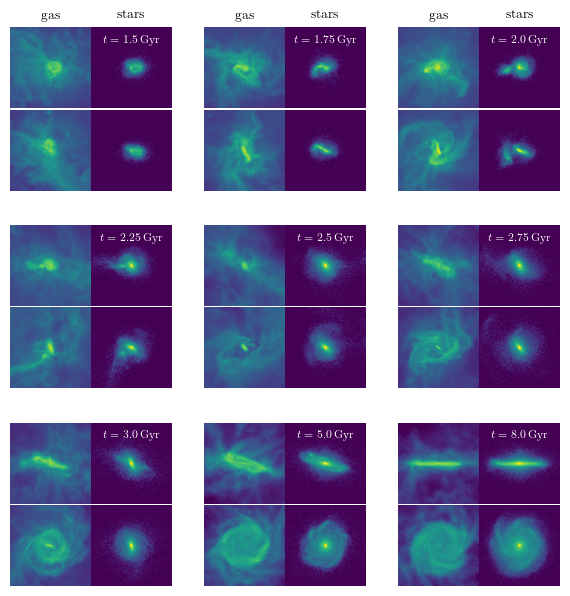

In [52]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(textwidth, 0.8*textheight))
outer = gridspec.GridSpec(3, 3)

idx_list = list(gal_idx.keys())

for i in range(9):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer[i], wspace=0, hspace=0)
    idx = idx_list[i]
    gal = gal_idx[idx]
    
    ax0 = plt.Subplot(fig, inner[0])
    ax1 = plt.Subplot(fig, inner[2])
    
    im0, im1 = plot_gas_panel(fig, ax0, ax1, sigma_xy[idx], sigma_xz[idx])
        
    ax0.set(xticks=[], yticks=[])
    ax1.set(xticks=[], yticks=[])
    
    if i < 3:
        ax0.set_title(r'$\textrm{gas}$')
    
    ax0.axis('off')
    ax1.axis('off')
    
    fig.add_subplot(ax0)
    fig.add_subplot(ax1)
        
    ax0 = plt.Subplot(fig, inner[1])
    ax1 = plt.Subplot(fig, inner[3])
        
    im0 = plot_star_panel(fig, ax0, gal, 0, 2)
    im1 = plot_star_panel(fig, ax1, gal, 0, 1)
    
    ax0.set(xticks=[], yticks=[])
    ax1.set(xticks=[], yticks=[])
    
    tstr = str(round(gal.sn.Time.value, 2))
    ax0.text(0, 9, r'$t='+tstr+r'\,\textrm{Gyr}$', c='w', fontsize=8, ha='center')
    
    if i < 3:
        ax0.set_title(r'$\textrm{stars}$')
    
    ax0.axis('off')
    ax1.axis('off')
    
    fig.add_subplot(ax0)
    fig.add_subplot(ax1)

# for ax in fig.axes:
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0, box.width, box.height])

# fig.tight_layout()
fig.savefig('surfdens.pdf')